# Emotion Detection using GloVe, CNN, and BiLSTM

#Objective

    The primary goal of this project is to detect emotions in text data using deep learning. The model is trained on labeled textual data and classifies each sentence into emotion categories (e.g., joy, sadness, anger). The approach integrates pre-trained GloVe embeddings, Convolutional Neural Networks (CNNs) for local feature extraction, and Bidirectional LSTM (BiLSTM) for sequential understanding.

# Dataset:

    Source: (assumed to be a public emotion classification dataset like the Emotion Dataset for NLP)

    Format: CSV/TSV with text and emotion labels

    Categories: Multiple classes (such as joy, anger, fear, sadness, etc.)

    Preprocessing:

    Tokenization

    Padding sequences

    Vocabulary construction

    Label encoding (one-hot or integer)

# Model Architecture:

    Embedding Layer (GloVe)

    Pre-trained GloVe embeddings (e.g., 100D or 200D) are used.

    The embedding matrix is created by mapping vocabulary words to GloVe vectors.

    These embeddings are non-trainable to preserve semantic quality.

 CNN Layer

    Applies 1D convolution to capture local n-gram features.

    Followed by MaxPooling1D to reduce sequence length and focus on dominant features.

 BiLSTM Layer

    A Bidirectional LSTM layer follows CNN to capture long-term dependencies in both forward and backward directions.

    Enhances understanding of context around emotion-indicating words.

 Dense + Dropout + Output

    Dense layer with dropout for regularization

    Final Dense layer with softmax activation for multi-class emotion prediction.

# **Model**

In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras # Import keras from tensorflow if using tf.keras
from tensorflow.keras.preprocessing.text import Tokenizer #Now this will work
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Bidirectional
from keras.layers import GlobalMaxPooling1D

In [3]:
train_df = pd.read_csv("/content/train.txt", sep=";", header= None, names=["text", "label"])
test_df = pd.read_csv("/content/test.txt", sep=";", header= None, names=["text", "label"])
val_df = pd.read_csv("/content/val.txt", sep=";", header= None, names=["text", "label"])

In [4]:
train_df.head()


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
test_df.head()


,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [6]:
val_df.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [7]:
train_df.info()
print()
test_df.info()
print()
val_df.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



In [8]:
train_df["label"].value_counts()

,count
label,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [9]:
test_df["label"].value_counts()

,count
label,
joy,695
sadness,581
anger,275
fear,224
love,159
surprise,66


In [10]:
val_df["label"].value_counts()

,count
label,
joy,704
sadness,550
anger,275
fear,212
love,178
surprise,81


In [11]:
# Combine for preprocessing
df = pd.concat([train_df, val_df, test_df])
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [12]:
# 2. Preprocess Data
X = df['text'].astype(str)
y = df['label']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Determine max length
max_len = max(len(seq) for seq in X_seq)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
file_path = '/content/drive/MyDrive/DATASETS/glove.840B.300d.txt'


In [15]:
embedding_index = {}
with open("/content/drive/MyDrive/DATASETS/glove.840B.300d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
        except ValueError:
            continue  # Skip lines that can't be converted


In [16]:
#
# Create Embedding Matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [17]:
# 4. Build Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_enc)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.build(input_shape=(None, 300))
model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 300)       │     5,129,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 148, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,428,690 (20.71 MB)

 Trainable params: 299,590 (1.14 MB)

 Non-trainable params: 5,129,100 (19.57 MB)

In [18]:
# 5. Train Model
history = model.fit(X_train, y_train,
                    epochs=1,
                    batch_size=128,
                    validation_data=(X_val, y_val))


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 410ms/step - accuracy: 0.4096 - loss: 1.5182 - val_accuracy: 0.6215 - val_loss: 0.9756


In [19]:
# 6. Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6134 - loss: 0.9981
Test Accuracy: 0.6105


# Text Preprocessing

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
import re
def lower_text(text):
    return text.lower()

def remove_number(text):
    return re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*').sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [22]:
def clean_text(text):
    text = lower_text(text)
    text = remove_number(text)
    text = remove_punct(text)
    text = remove_stopwords(text)

    return text

In [29]:
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)
val_df["clean_text"] = val_df["text"].apply(clean_text)

In [30]:
train_df.head()

,text,label,clean_text
0,i didnt feel humiliated,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,feeling grouchy


# Label encoding labels

In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df["encoded_train_label"] = label_encoder.fit_transform(train_df["label"])
val_df["encoded_val_label"] = label_encoder.transform(val_df["label"])
test_df["encoded_test_label"] = label_encoder.transform(test_df["label"])

In [32]:
train_df[['label', 'encoded_train_label']].drop_duplicates(keep='first')

,label,encoded_train_label
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [33]:
x_train, x_test, y_train, y_test = train_df["clean_text"], val_df["clean_text"], train_df["encoded_train_label"], val_df["encoded_val_label"]

In [34]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=4c4359c68060a3e6935927b9c28b47884bb1dcc469e060ba92f13fcf723a5e32
  Stored in directory: /root/.cache/pip/wheels/19/0d/33/eaa4dcda5799bcbb51733c0744970d10edb4b9add4f41beb43
Successfully built np_utils


In [35]:
pip install keras


In [37]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

In [39]:
# from keras.utils import np_utils
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from keras import layers
from keras.models import Sequential

EPOCHS= 30
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

**Converting texts to vectors via tokenization
**

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["clean_text"])

vocab_size = len(tokenizer.word_index) + 1

**Calculating maximum length of a vector**

In [41]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 35


Zero padding every vector so that they are the same size

In [42]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

One Hot Encoding integer labels

In [43]:
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
dummy_y_test = to_categorical(y_test)
dummy_y_train = to_categorical(y_train)

# Reading GloVe

In [48]:
import tqdm
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open("/content/drive/MyDrive/DATASETS/glove.840B.300d.txt", encoding='utf-8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [49]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 2196017it [03:21, 10917.50it/s]


# Defining an CNN-BiLSTM Model

In [53]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation=act))
model.add(layers.MaxPool1D(pool_size=3))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.build(input_shape=(None, 35))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 35, 300)        │     4,519,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 35, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 33, 32)         │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 9, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 512)            │       591,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,276,178 (20.13 MB)

 Trainable params: 5,276,178 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
checkpoint_filepath = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')


In [59]:
import os
import tensorflow as tf

checkpoint_dir = './Checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_filepath = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


In [60]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback])
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 227ms/step - accuracy: 0.3776 - loss: 1.5354 - val_accuracy: 0.5990 - val_loss: 0.9675
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.6231 - loss: 0.9522 - val_accuracy: 0.8505 - val_loss: 0.4749
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.8046 - loss: 0.5357 - val_accuracy: 0.8980 - val_loss: 0.3027
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.8728 - loss: 0.3578 - val_accuracy: 0.9115 - val_loss: 0.2553
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8985 - loss: 0.2942 - val_accuracy: 0.9215 - val_loss: 0.2259
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.9200 - loss: 0.2339 - val_accuracy: 0.9190 - val_loss: 0.2200
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.9280 - loss: 0.2042 - val_accuracy: 0.9210 - val_loss: 0.2224
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.9314 - loss: 0

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


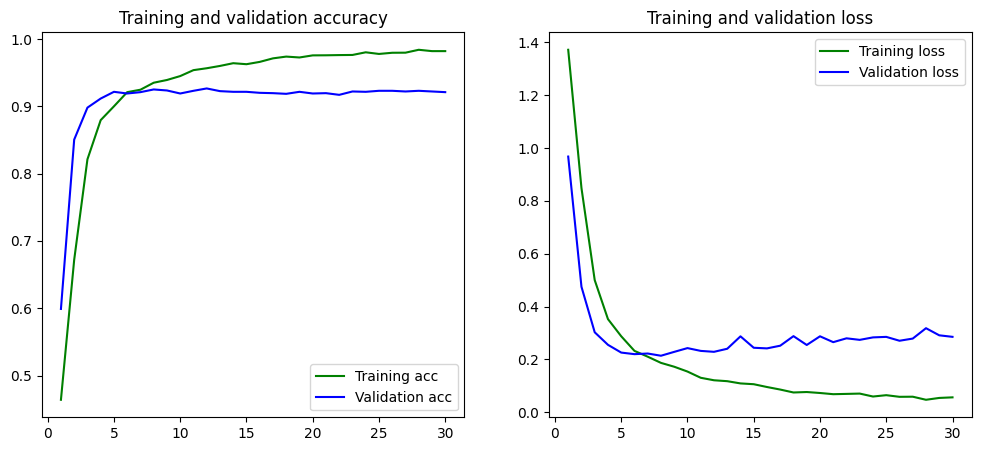

In [74]:
PlotGraph(history)

In [62]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.9265000224113464


In [63]:
model.load_weights(checkpoint_filepath)

In [64]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


array([4, 4, 4, ..., 2, 2, 1])

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["encoded_test_label"], predict_class)
cm

array([[244,  13,   3,   0,  14,   1],
       [  2, 214,   0,   0,   6,   2],
       [  0,   4, 649,  36,   2,   4],
       [  2,   0,  21, 134,   1,   1],
       [ 11,   6,   7,   1, 556,   0],
       [  2,  17,   4,   0,   2,  41]])

<Axes: >

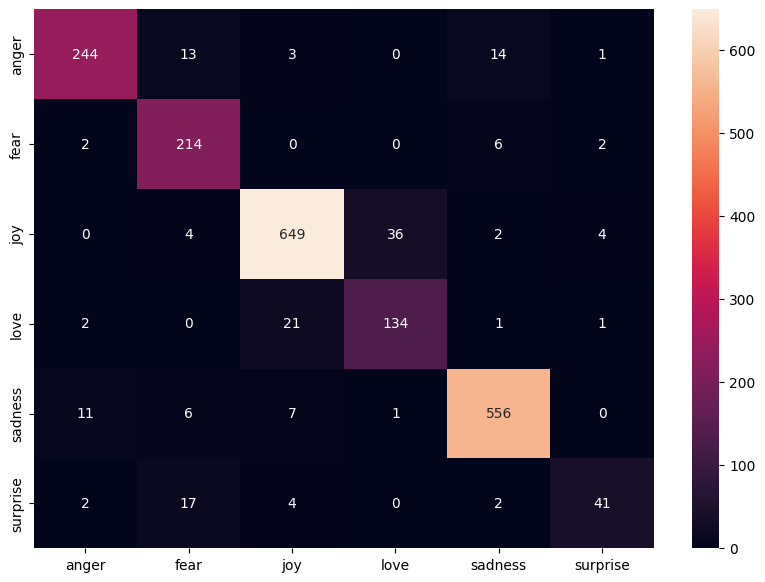

In [75]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "love", "sadness", "surprise"], columns=["anger", "fear", "joy", "love", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [76]:
from sklearn.metrics import classification_report

print(classification_report(test_df["encoded_test_label"], predict_class, target_names =["anger", "fear", "joy", "love", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.93      0.89      0.91       275
        fear       0.84      0.96      0.90       224
         joy       0.95      0.93      0.94       695
        love       0.78      0.84      0.81       159
     sadness       0.96      0.96      0.96       581
    surprise       0.84      0.62      0.71        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000

